We trying

Research Diary: https://drive.google.com/open?id=1zBXLaCameGhHj8RbXeGkep6_gZnUAiAnhGrVE1aEr-4

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import sklearn as sk
import scipy as sp
from scipy import signal
from copy import deepcopy
import math

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import sklearn.metrics

In [2]:
# Force divider function
def force_divider(x):
    k_outer = 3.738
    k_inner = 0.368
    dist = x/k_inner
    return (k_outer + k_inner)*dist

# FSR model function
def FSR_model(x):
    return 131.2*np.exp(0.7801*x)/1000

# Slope function
def slope(dataVector):
    dydx = []
    for i in range(1, len(dataVector)):
        diff = dataVector[i] - dataVector[i-1]
        dydx.append(diff)
    finalDiff = dataVector[i] - dataVector[i-1] # Added just to make the final array the proper dimensions 
    dydx.append(finalDiff)
    return np.array(dydx)

# Mean function
def mean(dataVec):
    return sum(dataVec) / len(dataVec)

# Standard Deviation
def sd(dataVec):
    avg = mean(dataVec)
    tot = 0
    for elem in dataVec:
        tot = tot + (elem - avg)*(elem - avg)
    return math.sqrt(tot / len(dataVec))

def impulse(data_matrix):
    #total impulse function for a single matrix of data 
    #iterates over data and computes the total impulse for all sensors over time 
    fsr_data = data_matrix[:,0:12]
    impulse = 0
    for col in np.arange(0,12):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1]- time[i]
            averagef = (single_FSR[i+1] + single_FSR[i])/2 
            impulse = impulse + averagef*delta_t
    return impulse 

def jerk(data_matrix): 
    #iterates over data and computes the max jerk for each sensor over time
    #takes the max jerk over all FSR sensors and returns  
    fsr_data = data_matrix[:,0:12]
    jerk_array = []
    for col in np.arange(0,12):
        single_FSR = data_matrix[:,col]
        time = data_matrix[:,0]
        all_jerks = []
        for i in np.arange(0,len(time)-1):
            delta_t = time[i+1] - time[i]
            delta_f = single_FSR[i+1] - single_FSR[i]
            all_jerks.append(delta_f/delta_t)
        jerk_array.append(np.amax(all_jerks))
    max_jerk = np.amax(jerk_array)
    return max_jerk

def max_force(data_matrix):
    #max force readings across all sensors for a single matrix of data 
    fsr_data = data_matrix[:,0:12]
    force_array = [] 
    for col in np.arange(0,12):
        single_FSR = data_matrix[:,col]
        max_force_sensor = np.amax(single_FSR)
        force_array.append(max_force_sensor)
    max_force = np.amax(force_array)
    return max_force

In [3]:
# Labels
    # Drop = 1
    # Nothing = 2
    # Squeeze = 3
    
# Add Fall data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/drop"
fsrData = []
accelData = []
totData = []
for num in np.arange(1, 21):
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrDrop = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelDrop = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totDrop = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrDrop = fsrDrop.to_numpy()
    accelDrop = accelDrop.to_numpy()
    totDrop = totDrop.to_numpy()
    fsrData.append(fsrDrop)
    accelData.append(accelDrop)
    totData.append(totDrop)
 
# Add Nothing data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/nothing"
for num in np.arange(1, 11):
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelNoth = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totNoth = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrNoth = fsrNoth.to_numpy()
    accelNoth = accelNoth.to_numpy()
    totNoth = totNoth.to_numpy()
    fsrData.append(fsrNoth)
    accelData.append(accelNoth)
    totData.append(totNoth)
    
# Add Squeeze data
string = "/Users/alber/Desktop/BEST/Tensegrity-HRI/DataV3/squeeze"
for num in np.arange(1, 35):
    filename = string + str(num) + '.csv'
    d = pd.read_csv(filename, names = ["IND", "time", "FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", 
                                               "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", "FSR_12",
                                              "ACC_X", "ACC_Y", "ACC_Z"])
    fsrSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12"]]
    accelSqueeze = d[["ACC_X", "ACC_Y", "ACC_Z"]]
    totSqueeze = d[["FSR_1", "FSR_2", "FSR_3", "FSR_4", "FSR_5", "FSR_6", "FSR_7", "FSR_8", "FSR_9", "FSR_10", "FSR_11", 
                 "FSR_12", "ACC_X", "ACC_Y", "ACC_Z"]]
    fsrSqueeze = fsrSqueeze.to_numpy()
    accelSqueeze = accelSqueeze.to_numpy()
    totSqueeze = totSqueeze.to_numpy()
    fsrData.append(fsrSqueeze)
    accelData.append(accelSqueeze)
    totData.append(totSqueeze)

# print(np.shape(fsrData))
# print(np.shape(accelData))
# print(np.shape(totData))


In [4]:
placeHold = []
for m in fsrData:
    m = force_divider(FSR_model(m *5/1023))  
    placeHold.append(m)

for k in totData:
    k[:, 0:12] = force_divider(FSR_model(k[:, 0:12] *5/1023))

fsrData = placeHold

Text(0.5, 1.0, 'Squeeze')

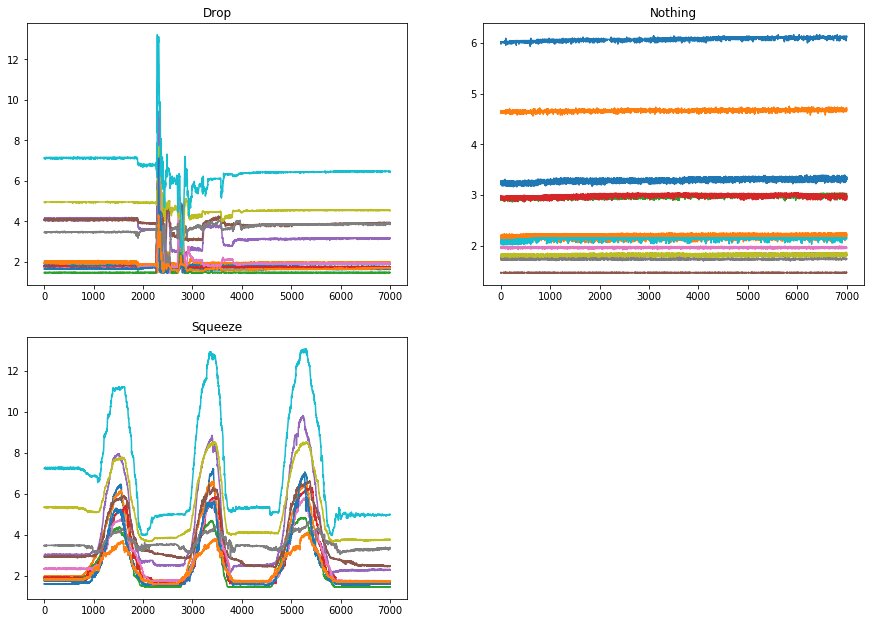

In [5]:
# Plot FSR data (Taking first tests as example)
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1, top = 0.9, hspace=0.2)
plt.subplot(221)
plt.plot(fsrData[0])
plt.title('Drop')
plt.subplot(222)
plt.plot(fsrData[20])
plt.title('Nothing')
plt.subplot(223)
plt.plot(fsrData[30])
plt.title('Squeeze')

In [6]:
# Trim FSR data-- 1000-6000 ms
fsrTrunc = []
for i in range(0, len(fsrData)):
    testTrunc = fsrData[i][:, :]
    fsrTrunc.append(testTrunc)
    
# print(np.shape(fsrData))

# plt.figure(figsize=(15, 20))
# plt.subplot(211)
# plt.plot(fsrData[30])
# plt.subplot(212)
# plt.plot(fsrTrunc[30])

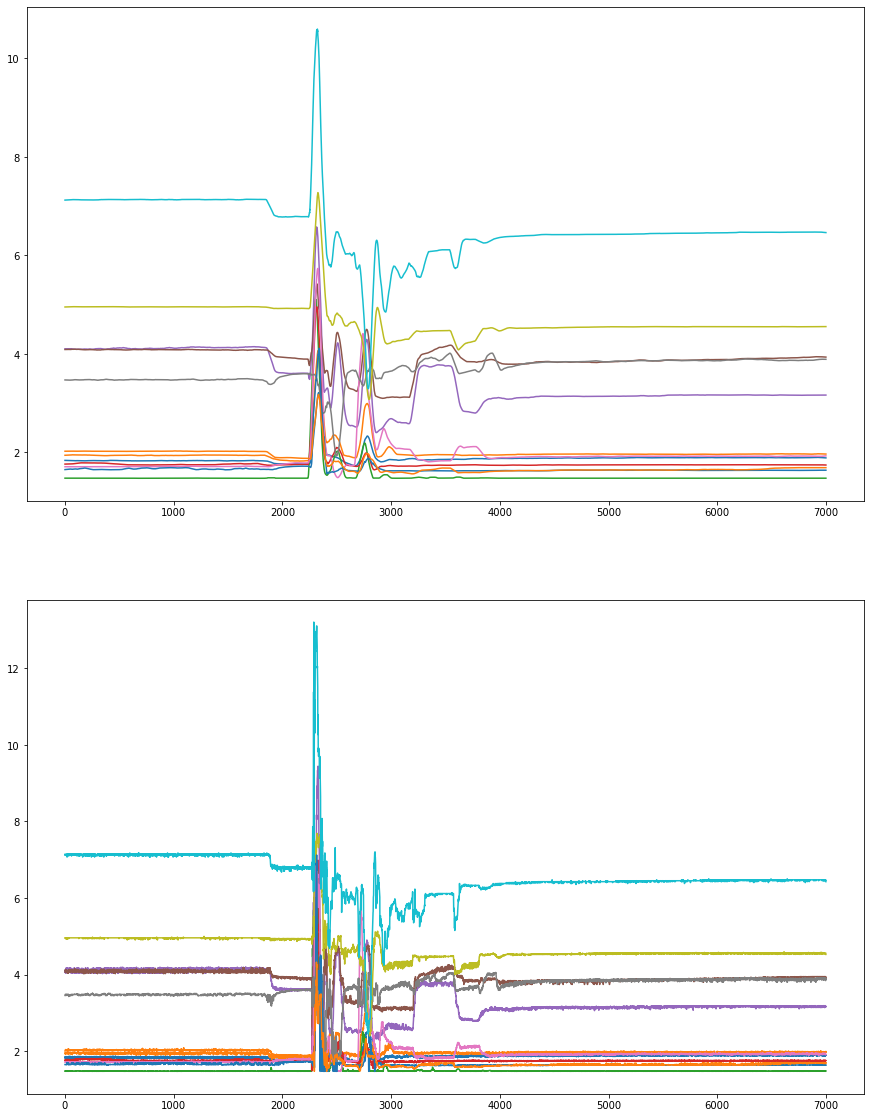

In [7]:
# Try smoothing out fsr data

fsrRefined = deepcopy(fsrTrunc)

for test in fsrTrunc:
    for k in range(0, 12):
        test[:, k] = signal.savgol_filter(test[:, k], 71, 1)       

plt.figure(figsize=(15, 20))
plt.subplot(211)
plt.plot(fsrData[0])
plt.subplot(212)
plt.plot(fsrRefined[0])

In [8]:
# Compress function
def compress(data):
    sliceLen = 30
    i = len(data) // sliceLen
    comp = []
    for k in range(0, i):
        vals = data[k*sliceLen:(k+1)*sliceLen]
        avg = mean(vals)
        comp.append(avg)
    return comp

(64, 7001, 12)
(64, 233, 12)


Text(0.5, 1.0, 'Squeeze')

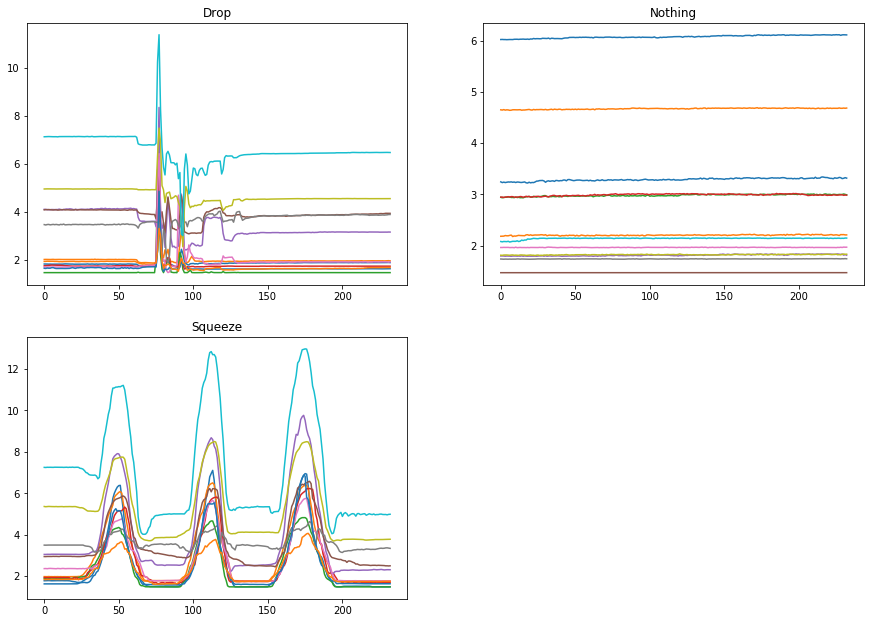

In [9]:
fsrComp = []
for test in fsrRefined:
    compArray = []
    for k in range(0, 12):
        com = compress(test[:, k])
        compArray.append(com)
    compArray = np.array(compArray)
    fsrComp.append(compArray.T)

print(np.shape(fsrRefined))
print(np.shape(fsrComp))
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1, top = 0.9, hspace=0.2)
plt.subplot(221)
plt.plot(fsrComp[0])
plt.title('Drop')
plt.subplot(222)
plt.plot(fsrComp[20])
plt.title('Nothing')
plt.subplot(223)
plt.plot(fsrComp[30])
plt.title('Squeeze')

In [10]:
feature_data = []
for m in fsrComp:
    maxf = max_force(m)
    i = impulse(m)
    features = [maxf, i]
    feature_data.append(features)


(64, 233, 1)


Text(0.5, 1.0, 'Squeeze')

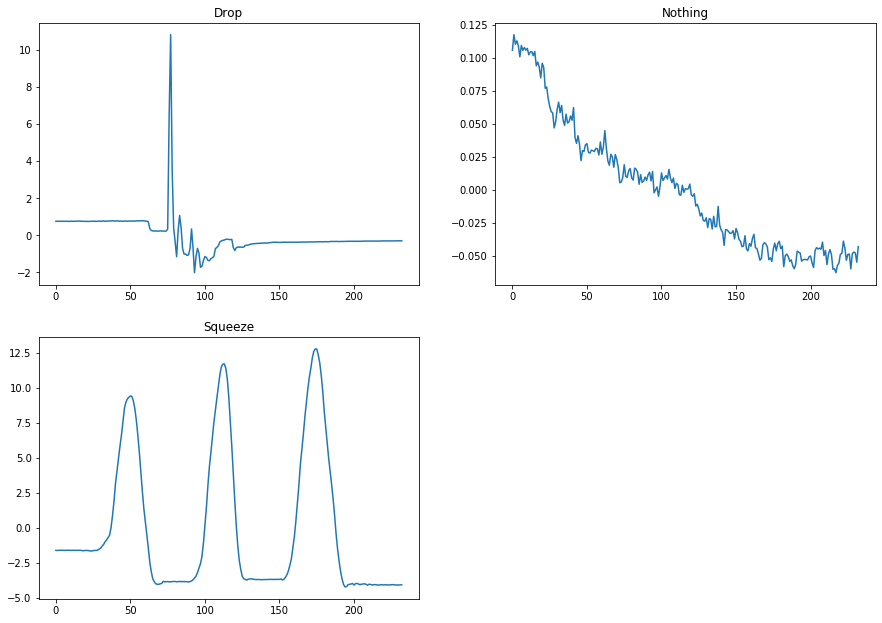

In [11]:
# PCA
pcaFSR = deepcopy(fsrComp)
pca = PCA(n_components = 1)

for i in range(0, len(pcaFSR)):
    pcaFSR[i] = pca.fit_transform(pcaFSR[i])


print(np.shape(pcaFSR))
plt.figure(figsize=(15, 10))
plt.subplots_adjust(bottom=0.1, top = 0.9, hspace=0.2)
plt.subplot(221)
plt.plot(pcaFSR[0])
plt.title('Drop')
plt.subplot(222)
plt.plot(pcaFSR[20])
plt.title('Nothing')
plt.subplot(223)
plt.plot(pcaFSR[30])
plt.title('Squeeze')



In [12]:
# Labels!

l1 = np.ones((20,), dtype=int) 
l2 = 2*np.ones((10,), dtype=int) 
l3 = 3*np.ones((34,), dtype=int)
labels = np.concatenate((l1, l2, l3), axis=0)

print(np.shape(labels))

(64,)


In [13]:
# Prepare data for algorithms
nsamples, nx, ny = np.shape(pcaFSR)
reformated_data = np.reshape(pcaFSR,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, labels, random_state=0)

# K-Fold Cross Validation
x = reformated_data
y = labels
skf = StratifiedKFold(n_splits=4)
skf.get_n_splits(x, y)

4

In [14]:
def prob_matrix(probs, labels):
    retMat = []
    l1Mat = [0, 0, 0]
    l2Mat = [0, 0, 0]
    l3Mat = [0, 0, 0]
    i = 0
    l1Count = 0
    l2Count = 0
    l3Count = 0
    for k in labels:
        if k == 1:
            l1Mat = l1Mat + probs[i]
            l1Count = l1Count + 1
        if k == 2:
            l2Mat = l2Mat + probs[i]
            l2Count = l2Count + 1
        if k == 3:
            l3Mat = l3Mat + probs[i]
            l3Count = l3Count + 1
        i = i + 1
    l1Mat = l1Mat / l1Count
    l2Mat = l2Mat / l2Count
    l3Mat = l3Mat / l3Count
    return np.array([l1Mat, l2Mat, l3Mat])

def generate_plot(probability_array, title):
    probability_array = probability_array.T
    label0 = probability_array[0]
    label1 = probability_array[1]
    label2 = probability_array[2]

 
    # The position of the bars on the x-axis
    r = [0,1,2]
 
    # Names of group and bar width
    names = ['Drop','Nothing','Squeeze']
    barWidth = 1
    
    plt.bar(r, label0, color = 'y',edgecolor='white', width=barWidth)
    plt.bar(r, label1, bottom=label0, color='g',edgecolor='white', width=barWidth)
    plt.bar(r, label2, bottom=label1+label0, color='b', edgecolor='white', width=barWidth)
    plt.legend(('1 (Drop)','2 (Nothing)','3 (Squeeze)'))
 
    plt.xticks(r, names)
    plt.xlabel("true test value")
    plt.ylabel('Probability')
    plt.title(title)

In [15]:
# Gaussian Naive-Bayes
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
    nb = GaussianNB().fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)

# print(np.shape(y_pred_tot))
print(np.shape(y_test_tot))
print(np.shape(all_probs))



1.0
Predicted labels = [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]
[[1.00000000e+000 0.00000000e+000 1.25383039e-145]
 [1.00000000e+000 0.00000000e+000 9.32868316e-115]
 [1.00000000e+000 0.00000000e+000 2.09821495e-107]
 [1.00000000e+000 0.00000000e+000 9.42842176e-080]
 [1.00000000e+000 0.00000000e+000 1.22890473e-115]
 [5.73538069e-125 1.00000000e+000 3.13974469e-317]
 [8.92197069e-123 1.00000000e+000 1.61736513e-315]
 [9.02583231e-128 1.00000000e+000 2.93420646e-319]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [1.32261943e-255 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [8.81043604e-186 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [5.78322524e-284 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00000000e+000]]


0.941176470588

[[7.97944334e-01 0.00000000e+00 2.02055666e-01]
 [9.99999385e-02 9.00000000e-01 6.14925101e-08]
 [3.67997461e-84 0.00000000e+00 1.00000000e+00]]


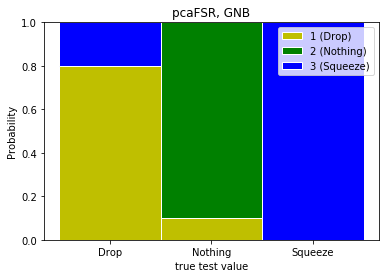

In [17]:
prob_mat = prob_matrix(all_probs, y_test_tot)
print(prob_mat)
generate_plot(prob_mat, 'pcaFSR, GNB')

0.9285714285714286
Predicted labels = [3 3 3 3 1 1 3 3 3 3 3 1 3 3]
Correct labels =   [3 3 3 3 1 1 3 3 3 3 1 1 3 3]
[[0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [1.00000000e+000 4.60779081e-118]
 [1.00000000e+000 1.33311372e-092]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]
 [2.27559821e-083 1.00000000e+000]
 [1.51293716e-044 1.00000000e+000]
 [1.00000000e+000 1.81222663e-042]
 [0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000]]




Text(0.5, 1.0, 'Drop vs. Squeeze ROC Curve')

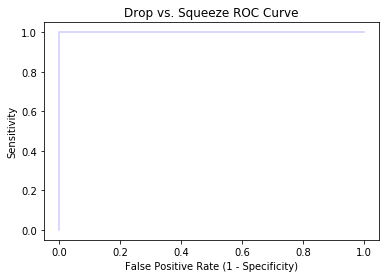

In [44]:
# Comparing labels 1 and 3 for ROC Curve
dropAndSqueeze = pcaFSR[0:20] + pcaFSR[30:64]
dropAndSqueezeLabels = np.concatenate((l1, l3), axis = 0)

nsamples, nx, ny = np.shape(dropAndSqueeze)
reformated_data = np.reshape(dropAndSqueeze,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, dropAndSqueezeLabels, random_state=0)

nb = GaussianNB().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
probs = nb.predict_proba(X_test)[:, 0]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, probs, pos_label=1)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Drop vs. Squeeze ROC Curve')

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)


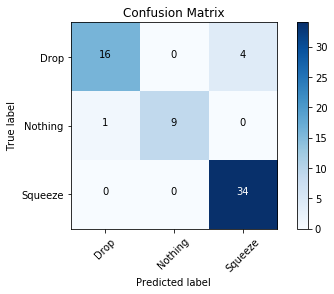

In [19]:
# Confusion Matrix

class_names = ['Drop', 'Nothing', 'Squeeze']
pcaFSR_cnf_matrix = confusion_matrix(y_test_tot, y_pred_tot)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix')

In [20]:
# Random Forest
y_pred_tot = []
y_test_tot = []
all_probs = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test, y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
    nb = RandomForestClassifier(n_estimators = 125).fit(X_train, y_train)
    print("\n")
    print(nb.score(X_test, y_test))
    y_pred = nb.predict(X_test)
    y_pred_tot.extend(y_pred)
    y_test_tot.extend(y_test)
    print("Predicted labels = " + str(y_pred))
    print("Correct labels =   " + str(y_test))
    print(nb.predict_proba(X_test))
    if len(all_probs) == 0:
        all_probs = nb.predict_proba(X_test)
    else:
        all_probs = np.append(all_probs, nb.predict_proba(X_test), axis = 0)

print(np.shape(y_test_tot))
print(np.shape(all_probs))



1.0
Predicted labels = [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]
[[0.936 0.056 0.008]
 [0.928 0.056 0.016]
 [0.728 0.264 0.008]
 [0.824 0.128 0.048]
 [0.672 0.312 0.016]
 [0.16  0.84  0.   ]
 [0.224 0.776 0.   ]
 [0.224 0.776 0.   ]
 [0.072 0.024 0.904]
 [0.184 0.072 0.744]
 [0.12  0.056 0.824]
 [0.088 0.032 0.88 ]
 [0.056 0.056 0.888]
 [0.096 0.016 0.888]
 [0.04  0.064 0.896]
 [0.016 0.016 0.968]
 [0.    0.    1.   ]]


0.8235294117647058
Predicted labels = [1 1 1 1 1 2 1 1 3 1 3 3 3 3 3 3 3]
Correct labels =   [1 1 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3]
[[0.992 0.008 0.   ]
 [0.688 0.312 0.   ]
 [0.704 0.008 0.288]
 [0.728 0.    0.272]
 [0.704 0.016 0.28 ]
 [0.096 0.904 0.   ]
 [0.944 0.056 0.   ]
 [0.936 0.064 0.   ]
 [0.184 0.088 0.728]
 [0.52  0.104 0.376]
 [0.392 0.08  0.528]
 [0.008 0.008 0.984]
 [0.008 0.008 0.984]
 [0.024 0.008 0.968]
 [0.008 0.008 0.984]
 [0.016 0.008 0.976]
 [0.    0.    1.   ]]


0.8666666666666667
Predicted labels

[[0.6464     0.2976     0.056     ]
 [0.276      0.6256     0.0984    ]
 [0.06682353 0.02047059 0.91270588]]


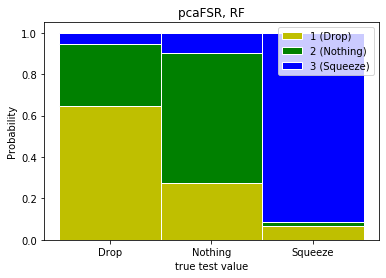

In [21]:
prob_mat = prob_matrix(all_probs, y_test_tot)
print(prob_mat)
generate_plot(prob_mat, 'pcaFSR, RF')

0.875
Predicted labels = [1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1]
Correct labels =   [1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 2]
[[1.  0. ]
 [0.9 0.1]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [0.9 0.1]
 [1.  0. ]
 [0.9 0.1]
 [1.  0. ]
 [0.9 0.1]
 [0.  1. ]
 [0.8 0.2]
 [0.8 0.2]
 [1.  0. ]
 [0.6 0.4]]


AUC: 0.9871794871794872


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


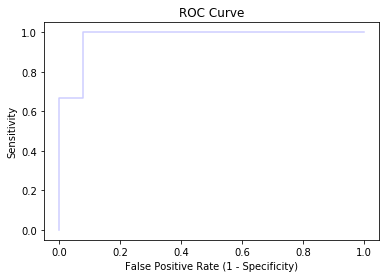

In [22]:
# Comparing labels for ROC Curve
l1 = 2*np.ones((20,), dtype=int) 
l2 = np.ones((44,), dtype=int) 
dropAndNothLabels = np.concatenate((l1, l2), axis = 0)

nsamples, nx, ny = np.shape(pcaFSR)
reformated_data = np.reshape(pcaFSR,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, dropAndNothLabels, random_state=0)

nb = RandomForestClassifier().fit(X_train, y_train)
print(nb.score(X_test, y_test))
y_pred = nb.predict(X_test)
print("Predicted labels = " + str(y_pred))
print("Correct labels =   " + str(y_test))
print(nb.predict_proba(X_test))
print("\n")

# Generate ROC Curve
prob2 = nb.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')

plt.title('ROC Curve')

print("AUC: " + str(roc_auc_score(y_test, prob2)))

In [31]:
# Looping over various parameters to systematically check AUC
l1 = np.ones((20,), dtype=int) 
l2 = np.ones((10,), dtype=int) 
l3 = 2*np.ones((34,), dtype=int)
twoLabels = np.concatenate((l1, l2, l3), axis = 0)

nsamples, nx, ny = np.shape(pcaFSR)
reformated_data = np.reshape(pcaFSR,(nsamples, nx*ny))
[X_train, X_test, y_train, y_test] = train_test_split(reformated_data, twoLabels, random_state=0)

aucArray = []
for param in np.arange(500, 1010, 10):
    aucSubArray = []
    for i in range(0, 5):
        nb = RandomForestClassifier(max_depth = param).fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        # Generate ROC Curve
        prob2 = nb.predict_proba(X_test)[:, 1]
        false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, prob2, pos_label=2)

        aucSubArray.append(roc_auc_score(y_test, prob2))
    aucArray.append([param, mean(aucSubArray)])
print(np.shape(aucArray))

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

(51, 2)


C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\alber\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

In [32]:
df = pd.DataFrame(aucArray, columns = ['Max Depth', 'AUC Scores'])
df.to_excel('C:/Users/alber/Desktop/BEST/Tensegrity-HRI/AUC_MD_3_ext.xlsx', sheet_name = 'Sheet1')

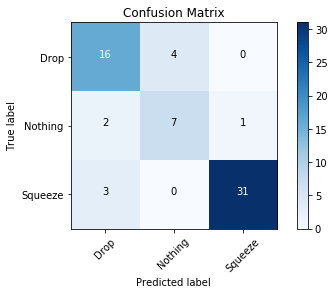

In [52]:
# Confusion Matrix

class_names = ['Drop', 'Nothing', 'Squeeze']
pcaFSR_cnf_matrix = confusion_matrix(y_test_tot, y_pred_tot)
plot_confusion_matrix(pcaFSR_cnf_matrix, classes=class_names, title='Confusion Matrix')